# Hard Labeling

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

In [3]:
sub_paths =[
    '/opt/ml/segmentation/moon/submission/ensemble_OCR_swinB_DS-ASPP_light+OCR_swinB_aux+DyHead_swinB+OCR_unet_swinB+dyunet_swinB+pseudo_deeplabv3p_swinB+OCR_dyunet_swinB_dyaux_weighted.csv',
    '/opt/ml/segmentation/moon/submission/ensemble_OCR_dyunetCBAM_swinB_cv2+OCR_dyunetCBAM_swinB_cv3+OCR_dyunetCBAM_swinB_cv4+OCR_dyunetCBAM_swinB_cv5.csv'
]
# sub_paths =[
#     '/opt/ml/segmentation/moon/submission/OCR_swinB_DS-ASPP_light_flipTTA.csv',
#     '/opt/ml/segmentation/moon/submission/OCR_swinB_aux_flipTTA.csv',
#     '/opt/ml/segmentation/moon/submission/DyHead_swinB_flipTTA.csv',
#     '/opt/ml/segmentation/moon/submission/OCR_unet_swinB_flipTTA.csv',
#     '/opt/ml/segmentation/moon/submission/dyunet_swinB_flipTTA.csv',
#     '/opt/ml/segmentation/moon/submission/pseudo_deeplabv3p_swinB_TTA.csv',
#     '/opt/ml/segmentation/moon/submission/OCR_dyunet_swinB_dyaux_flipTTA.csv'
# ]

model_names = [ '_'.join(os.path.splitext(s.split('/')[-1])[0].split('_')[:-1]) for s in sub_paths ]
MODEL = '+'.join(model_names)

In [5]:
MODEL = 'other+OCR_dyunetCBAM_swinB_cv2-5'

In [6]:
ensemble_sub = pd.read_csv('/opt/ml/segmentation/baseline_code/submission/sample_submission.csv', index_col=None)
submissions = [pd.read_csv(sub_path) for sub_path in sub_paths]
weights=[0.74,0.77]
#weights= [0.713,0.712,0.716,0.716,0.722,0.701,0.739]
#weights = [0.720,0.701,0.705,0.703,0.730,0.697,0.730,0.680,0.750] # LB scores
assert len(weights)==len(submissions)

In [7]:
count_maps=[]
for subs in tqdm(zip(*[submissions[i].iterrows() for i in range(len(submissions))])):
    subs = [(subs[j][1]) for j in range(len(subs))]
    preds = np.array([list(map(int,subs[j]['PredictionString'].split())) for j in range(len(subs))])
    file_name = subs[0]['image_id']
    
    count_map = np.zeros((11,256*256))

    ## 1. count_map : 각 pixel별로 순회하면서 어떤 label인지를 카운팅, 이 때 weight 적용
    ## 2. 각 pixel별로 가장 많이 counting된 label을 저장
    for pixel in range(256*256):
        pixel_preds = preds[:,pixel]
        for idx,pixel_pred in enumerate(pixel_preds):
            count_map[pixel_pred,pixel]+= weights[idx]*100
    
    ensemble_pred = count_map.argmax(axis=0).tolist()
    count_maps.append(count_map/(len(submissions)*100))

    ensemble_sub = ensemble_sub.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in ensemble_pred)}, 
                                   ignore_index=True)
                                   
ensemble_sub.to_csv(f"./submission/ensemble_{MODEL}_weighted.csv", index=False)

819it [02:56,  4.65it/s]


In [5]:
MODEL

'OCR_dyunet_swinB_dyaux+OCR_dyunet_swinB_dyaux_epoch40+OCR_dyunet_swinB_dyaux_epoch50'

---
# Soft Labeling

In [1]:
import os
from glob import glob
from tqdm import tqdm
import cv2
import pickle
import numpy as np
import albumentations as A
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

PATHS = [
    #'/opt/ml/segmentation/moon/ensemble/OCR_dyunetCBAM_swinB_cv1-5.pth',
    '/opt/ml/segmentation/moon/mmsegmentation/work_dirs/pseudo_OCR_dyunetCBAM_swinB_cv5/output.pth',
    '/opt/ml/segmentation/moon/mmsegmentation/work_dirs/pseudo_OCR_dyunetCBAM_swinB_cv1/output.pth',
    '/opt/ml/segmentation/moon/mmsegmentation/work_dirs/pseudo_OCR_dyunetCBAM_swinB_cv2/output.pth',
    '/opt/ml/segmentation/moon/mmsegmentation/work_dirs/pseudo_OCR_dyunetCBAM_swinB_cv3/output.pth',
    
        # '/opt/ml/segmentation/moon/mmsegmentation/work_dirs/OCR_dyunetCBAM_swinB_cv1',
        # '/opt/ml/segmentation/moon/mmsegmentation/work_dirs/OCR_dyunetCBAM_swinB_cv2',
        # '/opt/ml/segmentation/moon/mmsegmentation/work_dirs/OCR_dyunetCBAM_swinB_cv3',
        # '/opt/ml/segmentation/moon/mmsegmentation/work_dirs/OCR_dyunetCBAM_swinB_cv4',
        # '/opt/ml/segmentation/moon/mmsegmentation/work_dirs/OCR_dyunetCBAM_swinB_cv5',
] # 모델 저장된 폴더
# weights = [0.743,0.756,0.754,0.758,0.748] # lb score
# assert len(weights)==len(PATHS)

NAME = '+'.join([ path.split('/')[-1] for path in PATHS])

# LOGIT_PATHS = [glob(os.path.join(path,'output*')) for path in PATHS] # logit이 저장된 파일 이름 : output.pth

logits=None
for idx,logit_path in enumerate(tqdm(PATHS)):
    # assert len(logit_path)==1
    # logit_path = logit_path[0]
    with open(logit_path,'rb') as f:
        logit = np.array(pickle.load(f))

    if idx==0:
        logits=logit#*weights[idx]
    else:
        logits = logits+logit#*weights[idx]

logits /=len(PATHS)
        

100%|██████████| 4/4 [02:43<00:00, 40.93s/it]


---
ensemble 저장

In [3]:
MODEL = 'pseudo_OCR_dyunetCBAM_swinB_cv1,2,3,5'
PATH = '/opt/ml/segmentation/moon/ensemble'

if not os.path.exists(PATH):
    os.mkdir(PATH)

output2 = []
for i in range(len(logits)):
    output2.append(logits[i].astype(np.float16))

with open(os.path.join(PATH,f'{MODEL}.pth'),'wb') as f:
    pickle.dump(file=f,obj=output2)

---

In [3]:
output = [[] for _ in range(len(logits))]
for idx in tqdm(range(len(logits))):
    output[idx] = logits[idx].squeeze().argmax(axis=0)

100%|██████████| 819/819 [00:26<00:00, 30.80it/s]


In [4]:
size = 256
transform = A.Compose([A.Resize(size, size)])

DATAPATH = '/opt/ml/segmentation/moon/dataset/images/test'
file_names = sorted([ os.path.splitext(path)[0] for path in os.listdir(DATAPATH)])

preds_array = np.empty((0,size*size),dtype=np.int64)

for idx,out in tqdm(enumerate(output)):
    image = np.zeros((1,size,size))
    transformed = transform(image=image,mask=out)
    mask = transformed['mask']
    
    mask = mask.reshape(-1,size*size).astype(int)
    preds_array = np.vstack((preds_array,mask))

819it [05:58,  2.29it/s]


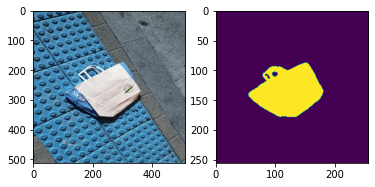

In [14]:
import matplotlib.pyplot as plt
idx=321
fig,axes = plt.subplots(1,2)
axes[0].imshow( cv2.imread(os.path.join('/opt/ml/segmentation/input/data/', '/'.join(file_names[idx].split('+'))) + '.jpg') )
axes[1].imshow( preds_array[idx].reshape(256,256))
plt.show()

In [5]:
NAME = 'pseudo_OCR_dyunetCBAM_swinB_cv1,2,3,5'

In [6]:
# sample_submisson.csv 열기
tmp_submission = pd.read_csv('/opt/ml/segmentation/baseline_code/submission/sample_submission.csv', index_col=None)

# PredictionString 대입
for file_name, string in zip(file_names, preds_array):
    file_name = '/'.join(file_name.split('+')) +'.jpg'
    tmp_submission = tmp_submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장

# 순서도 같아야 채점이 되기 때문에 sample_submission이 필요
sample = pd.read_csv('/opt/ml/segmentation/moon/submission/sample_submission.csv', index_col=None)
submission = pd.read_csv('/opt/ml/segmentation/baseline_code/submission/sample_submission.csv', index_col=None)
for image_id in sample['image_id'].tolist():
    prediction_string = tmp_submission[tmp_submission['image_id']==image_id]['PredictionString'].iloc[0]
    submission = submission.append({"image_id" : image_id, "PredictionString" : prediction_string }, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv(f"./submission/ensemble_{NAME}.csv", index=False)

---
# soft label CRF

In [92]:
crf_output = [[] for _ in range(len(logits))]
root = '/opt/ml/segmentation/input/data'

for idx,(logit,file_name) in tqdm(enumerate(zip(logits,file_names))):
    file_name = '/'.join(file_name.split('+')) +'.jpg'
    img = cv2.cvtColor(cv2.imread(os.path.join(root,file_name)),cv2.COLOR_BGR2RGB)
    crf_logit = dense_crf(img.reshape(1,3,512,512),logit.reshape(1,11,512,512))
    crf_output[idx] = crf_logit.squeeze().argmax(axis=0)

819it [2:28:26, 10.88s/it]


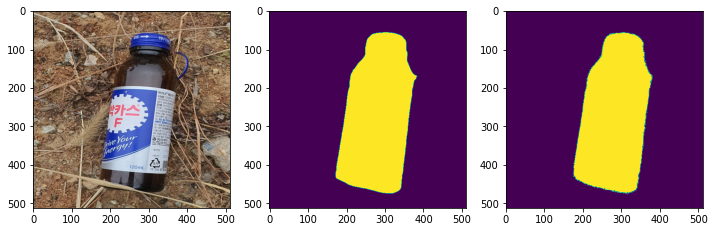

In [256]:
idx=654
fig,axes = plt.subplots(1,3,figsize=(12,9))
axes[0].imshow(cv2.cvtColor(cv2.imread(os.path.join(root,'/'.join(file_names[idx].split('+')) +'.jpg') ),cv2.COLOR_BGR2RGB))
axes[1].imshow(output[idx])
axes[2].imshow(crf_output[idx])

In [257]:
size = 256
transform = A.Compose([A.Resize(size, size)])

DATAPATH = '/opt/ml/segmentation/moon/dataset/images/test'
file_names = sorted([ os.path.splitext(path)[0] for path in os.listdir(DATAPATH)])

preds_array = np.empty((0,size*size),dtype=np.int64)

for idx,out in tqdm(enumerate(crf_output)):
    image = np.zeros((1,size,size))
    transformed = transform(image=image,mask=out)
    mask = transformed['mask']
    
    mask = mask.reshape(-1,size*size).astype(int)
    preds_array = np.vstack((preds_array,mask))

# sample_submisson.csv 열기
tmp_submission = pd.read_csv('/opt/ml/segmentation/baseline_code/submission/sample_submission.csv', index_col=None)

# PredictionString 대입
for file_name, string in zip(file_names, preds_array):
    file_name = '/'.join(file_name.split('+')) +'.jpg'
    tmp_submission = tmp_submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장

# 순서도 같아야 채점이 되기 때문에 sample_submission이 필요
sample = pd.read_csv('/opt/ml/segmentation/moon/submission/sample_submission.csv', index_col=None)
submission = pd.read_csv('/opt/ml/segmentation/baseline_code/submission/sample_submission.csv', index_col=None)
for image_id in sample['image_id'].tolist():
    prediction_string = tmp_submission[tmp_submission['image_id']==image_id]['PredictionString'].iloc[0]
    submission = submission.append({"image_id" : image_id, "PredictionString" : prediction_string }, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv(f"./submission/CRF_ensemble_{NAME}.csv", index=False)

819it [05:50,  2.33it/s]


---
# hard voting CRF

In [77]:
import cv2
import albumentations as A
import numpy as np
import pydensecrf.densecrf as dcrf
import pydensecrf.utils as utils
import matplotlib.pyplot as plt

def dense_crf(img, output_probs):
    MAX_ITER = 50
    POS_W = 3
    POS_XY_STD = 3
    Bi_W = 4
    Bi_XY_STD = 49
    Bi_RGB_STD = 5

    _,c,h,w = output_probs.shape

    U = utils.unary_from_softmax(output_probs.squeeze())

    U = np.ascontiguousarray(U)

    img = np.ascontiguousarray(img.squeeze().transpose(1,2,0)).astype(np.uint8) # 3x512x512

    d = dcrf.DenseCRF2D(w, h, c)
    d.setUnaryEnergy(U)
    d.addPairwiseGaussian(sxy=POS_XY_STD, compat=POS_W)
    d.addPairwiseBilateral(sxy=Bi_XY_STD, srgb=Bi_RGB_STD, rgbim=img, compat=Bi_W)

    Q = d.inference(MAX_ITER)
    Q = np.array(Q).reshape((1,c, h, w))
    return Q

In [ ]:
test_root = '/opt/ml/segmentation/input/data/'

In [ ]:
size=256
transform = A.Compose([A.Resize(size, size)])
for idx,rows in tqdm(enumerate(ensemble_sub.iterrows())):
    image = cv2.imread( test_root+ rows[1]['image_id'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transformed = transform(image=image)

    resized_image = transformed['image']
    mask = count_maps[idx].reshape(-1,256,256)

    crf_image = dense_crf(resized_image.reshape(1,3,256,256),mask.reshape(1,11,256,256))
    label = crf_image.argmax(axis=1).flatten().tolist()
    ensemble_sub.iloc[idx]['PredictionString'] = ' '.join(str(e) for e in label)

In [ ]:
ensemble_sub.to_csv(f"./submission/CRFensemble_{MODEL}_weighted.csv", index=False)